<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/EmployeeAttrition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Attrition - Case Study

We build and productionalize the model with Tensorflow, in Colab Cloud.

In [ ]:
#@title Load and Explore Data

from google.colab import files,data_table
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

## load data
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

## encode target
df['Attrition'] = (df['Attrition']=='Yes').astype('int32')

## confirm no nulls!
assert df.isna().sum().sum()==0
print('confirmed no nulls')

## see the percentage of attritions
print('average attrition:',df['Attrition'].mean())

## look at the data: mix of numeric and categorical features
data_table.DataTable( df )

Saving employee-attrition.csv to employee-attrition (1).csv
confirmed no nulls
average attrition: 0.16122448979591836


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [ ]:
#@title Feature Elimination

## eliminate unpredictive features

from sklearn.metrics import roc_auc_score

### trivial values
bad_cols = filter(lambda c:len(df[c].unique())==1,df.columns)
bad_cols = list(bad_cols)
for c in bad_cols:
  df.drop(c,axis=1,inplace=True)
print('dropping trivial cols:'+','.join(bad_cols))

### trivial predictive power
formulas = df.columns
formulas = filter(lambda t: t!='Attrition',formulas)
formulas = map(lambda t:(t,'Attrition~%s'%t),formulas)
models = map(lambda t: (t[0],smf.glm(t[1],data=df,family=sm.families.Binomial()).fit()),formulas)
models = filter(lambda t: roc_auc_score(df['Attrition'],t[1].fittedvalues)<0.51,models)
bad_cols = map(lambda t: t[0],models)
bad_cols = list(bad_cols)
print('droping unpredictive cols:',','.join(bad_cols))
for c in bad_cols:
  df.drop(c,axis=1,inplace=True)

dropping trivial cols:EmployeeCount,Over18,StandardHours
droping unpredictive cols: EmployeeNumber,HourlyRate,PerformanceRating


,Attrition
JobSatisfaction,
1,0.228374
2,0.164286
3,0.165158
4,0.113290


,Attrition
BusinessTravel,
Non-Travel,0.080000
Travel_Frequently,0.249097
Travel_Rarely,0.149569


,Attrition
OverTime,
No,0.104364
Yes,0.305288


,Attrition
WorkLifeBalance,
1,0.312500
2,0.168605
3,0.142217
4,0.176471


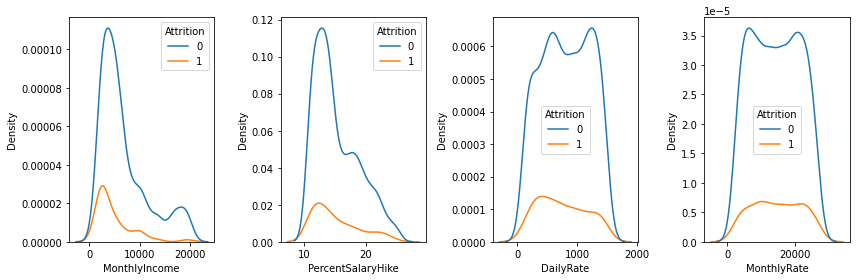

In [ ]:
#@title Featue Exploration
from matplotlib import pyplot as plt
import seaborn as sns

## numeric cols

cols = ['MonthlyIncome','PercentSalaryHike','DailyRate','MonthlyRate']
_,axs=plt.subplots(1,len(cols),figsize=(12,4))
for c,ax in zip(cols,axs):
  sns.kdeplot(data=df,x=c,hue='Attrition',ax=ax)
plt.tight_layout()

## categorical cols

from IPython.core.display import HTML,display

CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

cols = ['JobSatisfaction','BusinessTravel','OverTime','WorkLifeBalance']
for c in cols:
  tmp = df.groupby(c)[['Attrition']].mean()
  display(tmp)

## Modeling

In [ ]:
#@title Trivial Model

def evaluate(model):
  return (model.bic,roc_auc_score(df['Attrition'],model.fittedvalues))

model = smf.glm('Attrition~1',data=df,family=sm.families.Binomial())
model = model.fit()

print('BIC=%s,ROCAUC=%s'%evaluate(model))
model.summary()

BIC=-9414.860270755564,ROCAUC=0.5


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1469
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -649.29
Date:                Tue, 15 Jun 2021   Deviance:                       1298.6
Time:                        13:51:09   Pearson chi2:                 1.47e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6491      0.071    -23.252      0.000      -1.788      -1.510
==============================================================================
"""

### Non-Trivial Model

Here we use all features.

In [ ]:
cols = filter(lambda c:c!='Attrition' ,df.columns)
formula = 'Attrition~+'+'+'.join(cols)
model = smf.glm(formula,data=df,family=sm.families.Binomial())
model = model.fit()
print('BIC=%s,ROCAUC=%s'%evaluate(model))
model.summary()

BIC=-9547.969897343854,ROCAUC=0.8685686518080494


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1427
Model Family:                Binomial   Df Model:                           42
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -429.58
Date:                Tue, 15 Jun 2021   Deviance:                       859.17
Time:                        13:51:09   Pearson chi2:                 2.48e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -17.3028   1.27e+04     -0.001      0.999    -2.5e+04    2.49e+04
BusinessTravel[T.Travel_Frequently]      1.9131      0.411      4.653      0.000       1.107       2.719
BusinessTravel[T.Travel_Rarely]          1.0328      0.379      2.724      0.006       0.290       1.776
Department[T.Research & Development]    19.7498   1.27e+04      0.002      0.999   -2.49e+04     2.5e+04
Department[T.Sales]                     19.5764   1.27e+04      0.002      0.999   -2.49e+04     2.5e+04
EducationField[T.Life Sciences]         -0.7351      0.804     -0.914      0.361      -2.312       0.841
EducationField[T.Marketing]             -0.3353      0.853     -0.393      0.694      -2.008       1.337
EducationField[T.Medical]               -0.8316      0.804     -1.034      0.301      -2.407       0.744
EducationField[T.Other]                 -0.8072      0.864     -0.935      0.350      -2.500       0.886
EducationField[T.Technical Degree]       0.1912      0.823      0.232      0.816      -1.421       1.803
Gender[T.Male]                           0.3938      0.184      2.137      0.033       0.033       0.755
JobRole[T.Human Resources]              21.0048   1.27e+04      0.002      0.999   -2.49e+04     2.5e+04
JobRole[T.Laboratory Technician]         1.4874      0.483      3.078      0.002       0.540       2.434
JobRole[T.Manager]                       0.3838      0.887      0.433      0.665      -1.354       2.122
JobRole[T.Manufacturing Director]        0.2317      0.533      0.435      0.664      -0.812       1.276
JobRole[T.Research Director]            -1.0818      1.006     -1.076      0.282      -3.053       0.889
JobRole[T.Research Scientist]            0.5393      0.495      1.090      0.276      -0.431       1.509
JobRole[T.Sales Executive]               1.2064      1.124      1.074      0.283      -0.996       3.409
JobRole[T.Sales Representative]          2.1480      1.178      1.823      0.068      -0.162       4.458
MaritalStatus[T.Married]                 0.3239      0.266      1.216      0.224      -0.198       0.846
MaritalStatus[T.Single]                  1.1491      0.346      3.325      0.001       0.472       1.826
OverTime[T.Yes]                          1.9843      0.193     10.256      0.000       1.605       2.364
Age                                     -0.0308      0.014     -2.282      0.022      -0.057      -0.004
DailyRate                               -0.0003      0.000     -1.262      0.207      -0.001       0.000
DistanceFromHome                         0.0452      0.011      4.196      0.000       0.024       0.066
Education                                0.0035      0.088      0.041      0.968      -0.168       0.175
EnvironmentSatisfaction               

### Optimized Model

We eliminate variables related to: education, internal organization. This effect can be also achieved by a backward feature selection.

In [ ]:
df['extra'] =  df['MonthlyIncome'] > 7000
df['MonthlyIncome_offset'] = 0 #df['MonthlyIncome']-df.groupby(['JobLevel'])['MonthlyIncome'].transform('mean')

In [ ]:
cols = filter(lambda c:c!='Attrition' and c not in ['Department','EducationField','Education','JobRole','MonthlyRate','DailyRate','MonthlyIncome'] ,df.columns)
formula = 'Attrition~'+'+'.join(cols)
model = smf.glm(formula,data=df,family=sm.families.Binomial())
model = model.fit()
print('BIC=%s,ROCAUC=%s'%evaluate(model))
model.summary()

BIC=-9632.475418517834,ROCAUC=0.8564613768346558


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1445
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -452.97
Date:                Tue, 15 Jun 2021   Deviance:                       905.94
Time:                        13:51:09   Pearson chi2:                 2.70e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.4931      0.939      3.721      0.000       1.653       5.333
BusinessTravel[T.Travel_Frequently]     1.9563      0.408      4.792      0.000       1.156       2.756
BusinessTravel[T.Travel_Rarely]         1.1010      0.380      2.894      0.004       0.355       1.847
Gender[T.Male]                          0.4081      0.179      2.285      0.022       0.058       0.758
MaritalStatus[T.Married]                0.2974      0.260      1.146      0.252      -0.211       0.806
MaritalStatus[T.Single]                 1.1656      0.330      3.536      0.000       0.519       1.812
OverTime[T.Yes]                         1.8267      0.184      9.943      0.000       1.467       2.187
extra[T.True]                           1.2141      0.345      3.521      0.000       0.538       1.890
Age                                    -0.0287      0.013     -2.210      0.027      -0.054      -0.003
DistanceFromHome                        0.0438      0.010      4.240      0.000       0.024       0.064
EnvironmentSatisfaction                -0.4217      0.079     -5.316      0.000      -0.577      -0.266
JobInvolvement                         -0.5768      0.118     -4.869      0.000      -0.809      -0.345
JobLevel                               -0.7269      0.193     -3.776      0.000      -1.104      -0.350
JobSatisfaction                        -0.4120      0.078     -5.250      0.000      -0.566      -0.258
NumCompaniesWorked                      0.1878      0.037      5.131      0.000       0.116       0.260
PercentSalaryHike                      -0.0165      0.024     -0.697      0.486      -0.063       0.030
RelationshipSatisfaction               -0.2781      0.080     -3.457      0.001      -0.436      -0.120
StockOptionLevel                       -0.1930      0.148     -1.301      0.193      -0.484       0.098
TotalWorkingYears                      -0.0746      0.028     -2.680      0.007      -0.129      -0.020
TrainingTimesLastYear                  -0.1543      0.070     -2.206      0.027      -0.291      -0.017
WorkLifeBalance                        -0.2765      0.117     -2.356      0.018      -0.507      -0.046
YearsAtCompany                          0.0961      0.037      2.567      0.010       0.023       0.170
YearsInCurrentRole                     -0.1482      0.044     -3.372      0.001      -0.234      -0.062
YearsSinceLastPromotion                 0.1667      0.040      4.139      0.000       0.088       0.246
YearsWithCurrManager                   -0.1275      0.045     -2.843      0.004      -0.215      -0.040
MonthlyIncome_offset                         0          0        nan        nan           0           0
===================================================================

### Models for Hypothesis Testing

Do business travels affect more males or females?

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'Attrition~0+JobSatisfaction+EnvironmentSatisfaction+RelationshipSatisfaction+MaritalStatus+OverTime+C(BusinessTravel):C(Gender)'

model = smf.glm(formula,data=df,family=sm.families.Binomial())
model = model.fit()

print(evaluate(model))
model.summary()

(-9544.660489514874, 0.7766638947919554)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1458
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -544.28
Date:                Tue, 15 Jun 2021   Deviance:                       1088.6
Time:                        13:51:09   Pearson chi2:                 1.57e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
MaritalStatus[Divorced]                                     -2.0147      0.735     -2.740      0.006      -3.456      -0.573
MaritalStatus[Married]                                      -1.7198      0.721     -2.386      0.017      -3.133      -0.307
MaritalStatus[Single]                                       -0.6988      0.719     -0.972      0.331      -2.107       0.710
OverTime[T.Yes]                                              1.5926      0.162      9.827      0.000       1.275       1.910
C(Gender)[T.Male]                                            0.8937      0.752      1.189      0.235      -0.580       2.367
C(BusinessTravel)[T.Travel_Frequently]:C(Gender)[Female]     1.9816      0.694      2.856      0.004       0.622       3.342
C(BusinessTravel)[T.Travel_Rarely]:C(Gender)[Female]         1.0697      0.670      1.597      0.110      -0.243       2.382
C(BusinessTravel)[T.Travel_Frequently]:C(Gender)[Male]       1.1700      0.427      2.741      0.006       0.333       2.007
C(BusinessTravel)[T.Travel_Rarely]:C(Gender)[Male]           0.6403      0.391      1.636      0.102      -0.127       1.408
JobSatisfaction                                             -0.3345      0.070     -4.796      0.000      -0.471      -0.198
EnvironmentSatisfaction                                     -0.3489      0.071     -4.893      0.000      -0.489      -0.209
RelationshipSatisfaction                                    -0.2010      0.071     -2.823      0.005      -0.341      -0.061
============================================================================================================================
"""

## TF Model

We will build a model...

### Build and Train

In [ ]:
import pandas as pd
import tensorflow as tf
import itertools

# Step 0 - build tensorlow data set (here: in memory; for larger datasets iterators can be consumed)

N_BATCH = 32
x_cols = list(filter(lambda c: c!='Attrition',df.columns))
y_col = 'Attrition'

df_train = df[x_cols]

ds=tf.data.Dataset.from_tensor_slices((dict(df_train[x_cols]),df[y_col])).shuffle(1000).batch(N_BATCH).repeat(400)
x,y = next(ds.as_numpy_iterator())

# Step 1 - feature encoder

category_cols = filter(lambda t:not pd.api.types.is_numeric_dtype(df.dtypes.get(t)),x_cols)
category_cols = map(lambda t: (t,df[t].unique()[1:],category_cols),category_cols)
category_cols = map(lambda t: tf.feature_column.categorical_column_with_vocabulary_list(t[0],t[1]),category_cols)
category_cols = map(tf.feature_column.indicator_column,category_cols)

numeric_cols = filter(lambda t:pd.api.types.is_numeric_dtype(df.dtypes.get(t)),x_cols)
numeric_cols = map(tf.feature_column.numeric_column,numeric_cols)

cols = itertools.chain(category_cols,numeric_cols)
cols = list(cols)

# Step 2 - linear model

class FeaturesLinModel(tf.keras.Model):

  ''' implements a logistic classifier with given tf features (of various type) '''

  def __init__(self,features,n_class=2):
    super(FeaturesLinModel,self).__init__()
    self.FeatureLayer = tf.keras.layers.DenseFeatures(features)
    self.NormalizeLayer = tf.keras.layers.BatchNormalization()
    self.DenseLayer = tf.keras.layers.Dense(n_class,
                                            kernel_regularizer=tf.keras.regularizers.l1(1e-3),
                                            activation='sigmoid')

  def call(self,inputs):
    x = inputs
    x = self.FeatureLayer(x)
    x = self.NormalizeLayer(x)
    x = self.DenseLayer(x)
    return x

# Step 3 - train
model = FeaturesLinModel(cols,1)
model.compile(tf.keras.optimizers.Adam(),tf.keras.losses.BinaryCrossentropy(from_logits=False))
model.fit(ds)


# roc_auc_score(df['Attrition'],model(dict(df_train)).numpy().ravel())

18400/18400 [==============================] - 64s 3ms/step - loss: 0.3140


### Deploy

In [ ]:
#@title Model saving and versioning

import os
import tempfile

MODEL_DIR = tempfile.gettempdir()
os.environ["MODEL_DIR"] = MODEL_DIR
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

model.save(
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 900
drwxr-xr-x 2 root root   4096 Jun 15 13:48 assets
-rw-r--r-- 1 root root  17568 Jun 15 13:52 keras_metadata.pb
-rw-r--r-- 1 root root 889513 Jun 15 13:52 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun 15 13:52 variables


In [ ]:
#@title Model metadata

!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Age'] tensor_info:
        dtype: DT_INT64
        shape: (-1, 1)
        name: serving_default_Age:0
    inputs['BusinessTravel'] tensor_info:
        dtype: DT_STRING
        shape: (-1, 1)
        name: serving_default_BusinessTravel:0
    inputs['DailyRate'] tensor_info:
        dtype: DT_INT64
        shape: (-1, 1)
        name: serving_default_DailyRate:0
    inputs['Department'] tensor_info:
        dtype: DT_STRING
        shape: (-1, 1)
        name: serving_default_Departm

In [ ]:
#@title Install TensorFlow Serving
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl -s https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt -qq update
!apt-get -q install tensorflow-model-server


In [ ]:
#@title Start Model
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=attrition_model --model_base_path="/attrition_model" >server.log 2>&1

#!ps aux | grep -i "tensorflow_model_server"
#!kill -9 1971

In [ ]:
!ls

In [ ]:
#@title Logs and Status
!tail server.log

!curl http://localhost:8501/v1/models/attrition_model

### Real-Time Predictions

In [ ]:
#@title User Input (Friendly API)

## grab user data (interactive!)

Age = 41 #@param
BusinessTravel = 'Travel_Frequently' #@param ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
DailyRate =  1102 #@param
Department = 'Sales' #@param ['Sales', 'Research & Development', 'Human Resources']
DistanceFromHome = 1 #@param
Education =  2#@param
EducationField = 'Human Resources' #@param ['Life Sciences', 'Other', 'Medical', 'Marketing','Technical Degree', 'Human Resources']
EnvironmentSatisfaction = 2 #@param
Gender = 'Male' #@param ['Female', 'Male']
JobInvolvement = 3 #@param
JobLevel = 2 #@param
JobRole = 'Sales Executive' #@param ['Sales Executive', 'Research Scientist', 'Laboratory Technician','Manufacturing Director','Healthcare Representative','Manager','Sales Representative', 'Research Director', 'Human Resources']
JobSatisfaction = 4 #@param
MaritalStatus = 'Married' #@param ['Single', 'Married', 'Divorced']
MonthlyIncome = 5993 #@param
MonthlyRate = 19479 #@param
NumCompaniesWorked = 8 #@param
OverTime = 'Yes' #@param ['Yes','No']
PercentSalaryHike = 11 #@param
RelationshipSatisfaction = 1 #@param
StockOptionLevel = 0 #@param
TotalWorkingYears = 8 #@param
TrainingTimesLastYear = 0 #@param
WorkLifeBalance =  2#@param
YearsAtCompany =  1#@param
YearsInCurrentRole =  1#@param
YearsSinceLastPromotion = 0 #@param
YearsWithCurrManager =  1#@param

data = dict(
  Age=Age,
  BusinessTravel=BusinessTravel,
  DailyRate=DailyRate,
  Department=Department,
  DistanceFromHome=DistanceFromHome,
  Education=Education,
  EducationField=EducationField,
  EnvironmentSatisfaction=EnvironmentSatisfaction,
  Gender=Gender,
  JobInvolvement=JobInvolvement,
  JobLevel=JobLevel,
  JobRole=JobRole,
  JobSatisfaction=JobSatisfaction,
  MaritalStatus=MaritalStatus,
  MonthlyIncome=MonthlyIncome,
  MonthlyRate=MonthlyRate,
  NumCompaniesWorked=NumCompaniesWorked,
  OverTime=OverTime,
  PercentSalaryHike=PercentSalaryHike,
  RelationshipSatisfaction=RelationshipSatisfaction,
  StockOptionLevel=StockOptionLevel,
  TotalWorkingYears=TotalWorkingYears,
  TrainingTimesLastYear=TrainingTimesLastYear,
  WorkLifeBalance=WorkLifeBalance,
  YearsAtCompany=YearsAtCompany,
  YearsInCurrentRole=YearsInCurrentRole,
  YearsSinceLastPromotion=YearsSinceLastPromotion,
  YearsWithCurrManager=YearsWithCurrManager
)

## serialize data

js = [{k:[v] for k,v in data.items() if k in x_cols}]
js = json.dumps({"signature_name": "serving_default", "instances": js})

## prepare and send the request

headers = {"content-type": "application/json"}
js_response = requests.post('http://localhost:8501/v1/models/attrition_model:predict', data=js, headers=headers)

## look at the response
json.loads(js_response.text)
